# Dynamics, Linear Systems and Equilibria Review

```{contents}
:local:
:depth: 1
```

## Continuous Time Dynamics

The dynamics of a smooth system can generally be defined as

$$\dot{x} = f(x,u)$$

where $\dot{x}$ is the time derivative of the "state" $x\in\mathbb{R}^N$. The control "input" is $u\in\mathbb{R}^M$.

```{note}
The size of $\dot{x}$ is not necessarily the same as $x$ such as in the case of [derivatives of rotations](https://manipulation.csail.mit.edu/pick.html#jacobian) {cite:p}`manipulation`.
```

For a mechanical system, the state is usually stacked positions and veclocities known as the "configuration".

$$
x=\left[\begin{array}{l}
q \\
v
\end{array}\right]
$$

### Example Pendulum 

Simple pendulum dynamics are given as:

$$
m l^2 \ddot{\theta}+m y l \sin (\theta)=u
$$

![pendulum](images/pendulum.png)

Then the pendulum can be represented as a system of first order ODEs with:

$$
x=\left[\begin{array}{l}
\theta \\
\dot{\theta}
\end{array}\right] \Rightarrow \dot{x}=\left[\begin{array}{l}
\dot{\theta} \\
\dot{\theta}
\end{array}\right]=\left[\begin{array}{c}
\dot{\theta} \\
-\frac{9}{l} \sin (\theta)+\frac{1}{m l^2} u
\end{array}\right]
$$

$q\in\mathbb{S}^1$ (a circle) and $x\in\mathbb{S}^1 \times \mathbb{R}$ (a cyclinder).


In [1]:
# Activate the enironment
import Pkg 
Pkg.activate(@__DIR__); # activate the env in the directory 
# Pkg.instantiate()
using Plots

function dynamics(params::NamedTuple, x::Vector, u)
    # pendulum ODE, parametrized by params. 

    m, l, g = params.m, params.l, params.g
    
    θ = x[1]
    dθ= x[2]

    # return [dθ; -g/l * sin(θ) + u/(m*l^2) - dθ] # Try adding a damping term to the system
    return [dθ; -g/l * sin(θ) + u/(m*l^2)]

end

function rk4(params::NamedTuple, x::Vector, u , dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end


  Activating project at `/workspaces/CMU-16-745/optimalcontrol`


rk4 (generic function with 1 method)

In [2]:

function animate_pendulum(params, t, X)
    anim = @animate for i in 1:length(t)
        x = [0; params.l * sin(X[1, i])]
        y = [0; -params.l * cos(X[1, i])]
        view = 2 * params.l
        plot(x,y, color=:blue, label="")
        plot!([x[2]], [y[2]], seriestype=:scatter, color=:blue, label="")
        plot!(xlims=(-view, view),
            ylims=(-view, view),
            aspect_ratio=:equal)
        plot!(title="t = "*string(t[i]))
    
    end
    gif(anim, show_msg=false)
end


animate_pendulum (generic function with 1 method)

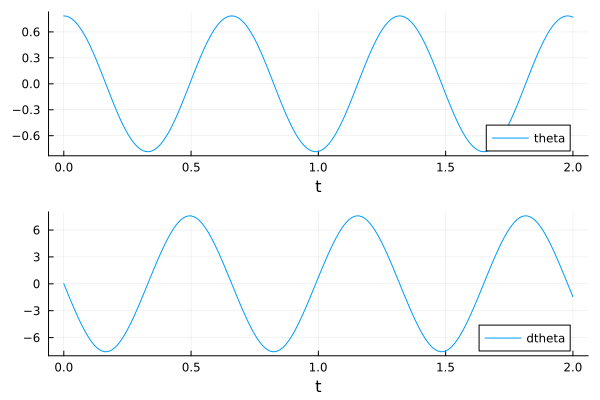

In [3]:
# Define the pendulum params
params = (m=0.1,l=0.1, g=9.81)

# Preallocate
dt = 0.01
t = 0:dt:2
X = zeros(2, length(t))
X[:,1] = [π/4, 0] # initial condition
u = 0

# Simulate
for i in 1:length(t)-1
    X[:,i+1] = rk4(params, X[:,i], u , dt)
end

# Plot
plot(t, X', layout=(2,1), label=["theta" "dtheta"])
plot!(xlabel="t")

Plots.AnimatedGif("/tmp/jl_dS5OFsP65u.gif")
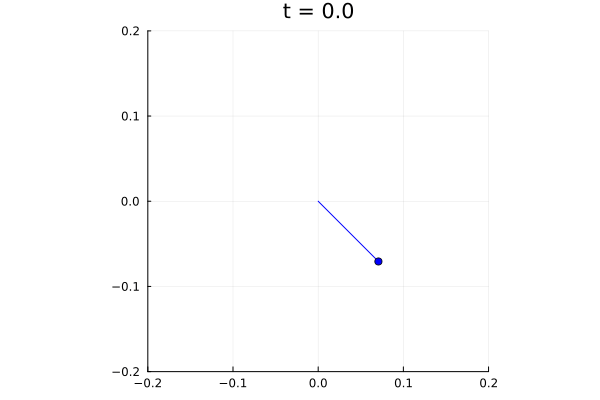

In [4]:
animate_pendulum(params, t, X)


## Control - Affine Systems

A system is "control affine" if it can be put in the form 

$$
\dot{x} = f(x) + B(x)u
$$

Most systems can be put in this form.

## Manipulator Dynamics

$$
M(q)\dot{v} + C(q,v) = B(q)u + F
$$

Where $M$ is the mass matrix, $C$ is the Coriolis and gravity terms, $B$ is the input Jacobian and $F$ are external forces. 

All mechanical systems can be written like this.

It is a rearranging of the Euler-Lagrange equation 

$$
L=\frac{1}{2} v^{\intercal} M(q) v - U(q)
$$

Which is the kinetic energy minus the potential energy.

## Linear Systems

The system is linear in $x$ and $u$ if it is of the form

$$
\dot{x} = A(t) x + B(t) u
$$

It is time invariant if $A(t) = A$ and $B(t) = B$ (ie constant).

Nonlinear systems are often approximated with linear systems.

$$
\dot{x} = f(x,u)  \implies A = \frac{\partial f}{\partial x}, B = \frac{\partial f}{\partial u}
$$

## Equilibria

A point where the system will "remain at rest"

$$
\implies \dot{x} = f(x,u) = 0
$$

Algebraically, these are the roots of the dynamics.

For example the pendulum 

$$
\dot{x}=\left[\begin{array}{c}
\dot{\theta} \\
\frac{-g}{l} \sin (\theta)
\end{array}\right]=\left[\begin{array}{l}
0 \\
0
\end{array}\right] \Rightarrow \begin{aligned}
& \dot{\theta}=0 \\
& \theta=0, \pi
\end{aligned}
$$

But in general we have a root-finding problem in $u$. That is 

$$
f(x^*, u) = 0
$$

### First Control Example

For the pendulum system we can introduce a control to achieve a desired set point.

$$
\dot{x}=\left[\begin{array}{c}
\dot{\theta} \\
\frac{-g}{l} \sin (\frac{\pi}{2}) + \frac{1}{ml^2}u
\end{array}\right]=\left[\begin{array}{l}
0 \\
0
\end{array}\right]
$$

This is analytic

$$
\frac{1}{m l^2} u=\frac{g}{l} \sin (\pi / 2) \Rightarrow u=m g l
$$

Though this doesn't work well, here or in practice, due to the control lagging the system state (sensor readings).

To counter this let's use this as a feedforward controller and cancel out and disturbances with a PD term. So we will have a feedforward PD controller.


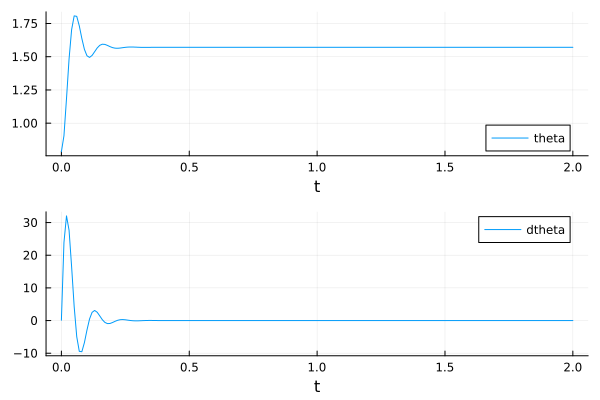

In [5]:
# Now what if we force it
X[:,1] = [π/4; 0.1]

# With only feedforward term, small errors cause instability (in sim, in model, unmodelled)
# Try changing the gains to zero to demonstrate this
# Note that a real system might have daming to counter this
function feedforward_pd(setpoint::Vector, X::Vector, kp, kd)
    # Cancel the velocity
    ex = setpoint[1] - X[1] # Pid term
    ev = setpoint[2] - X[2] # Velocity damping
    ff = params.m*params.g*params.l # Feed forward torque
    return kp*ex + kd*ev + ff 
end

# Simualte with control
for i in 1:length(t)-1
    u = feedforward_pd([π/2; 0.0], X[:,i], 3, 0.05)
    X[:,i+1] = rk4(params, X[:,i], u , dt)
end

# Plot
plot(t, X', layout=(2,1), label=["theta" "dtheta"]);
plot!(xlabel="t")

Plots.AnimatedGif("/tmp/jl_roBU9qR4du.gif")
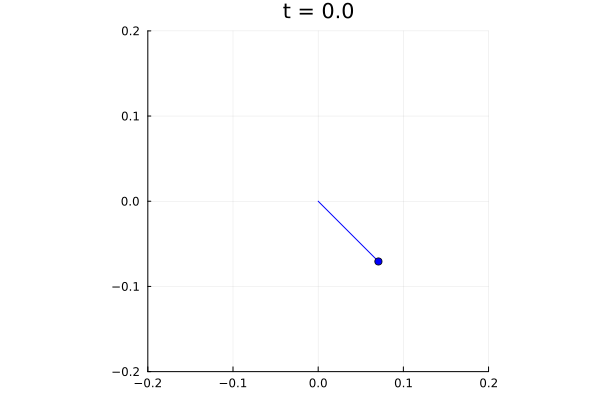

In [6]:
animate_pendulum(params, t, X)

## Stability of Equilibria

A system is at a stable equilibrium point if it will stay "near" that point under "perturbations".

For example a 1D system

![](images/1D_equilibria.png)

This implies

$$
\frac{\partial f}{\partial x} < 0 \implies \text{stable} \\
\frac{\partial f}{\partial x} > 0 \implies \text{unstable}
$$

In higher dimensions 
$
\frac{\partial f}{\partial x} \text{is a Jacobian}
$

An eigen decomposition tells us if it is stable or not

$$
\text{Re}[\text{eig}(\frac{\partial f}{\partial x})] < 0 \implies \text{stable} \\
\text{otherwise} \implies \text{unstable}
$$

### Example: Pendulum Stability

The system is unstable at $\theta=\pi$ without control

In [16]:
import ForwardDiff as FD
using LinearAlgebra
u = 0
# At π
∂f∂x = FD.jacobian( x->dynamics(params, x, u), [π; 0])
eigvals(∂f∂x)

2-element Vector{Float64}:
 -9.904544411531505
  9.904544411531507

Pure imaginary values is called "marginally" stable

In [17]:
# At 0
∂f∂x = FD.jacobian( x->dynamics(params, x, u), [0; 0])
eigvals(∂f∂x)

2-element Vector{ComplexF64}:
 -0.0 - 9.904544411531507im
  0.0 + 9.904544411531507im

What about with our ideal control

In [19]:
# At π/2 with our ideal control
u = params.g*params.m*params.l
∂f∂x = FD.jacobian( x->dynamics(params, x, u), [π/2; 0])
eigvals(∂f∂x)

2-element Vector{ComplexF64}:
 -0.0 - 7.750414537183006e-8im
  0.0 + 7.750414537183006e-8im

In [22]:
# What about with our PD controller
X = [π/2; 0]
u = feedforward_pd(X, X, 3, 0.05)
∂f∂x = FD.jacobian( x->dynamics(params, x, u), X)
eigvals(∂f∂x)

2-element Vector{ComplexF64}:
 -0.0 - 7.750414537183006e-8im
  0.0 + 7.750414537183006e-8im

Adding damping will result in a strictly negative real part.